In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
from arrSTick import CNNModel, Tools
from tensorflow.keras.utils import plot_model
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import importlib
import tensorflow as tf

In [2]:
# load the receptor labels and the training sequences
dataset = pd.read_csv("data/training_data.tab", sep="\t", index_col=0).set_index("Uniprot_Name").iloc[:113]
sequences = pd.read_csv('data/training_seq.csv', index_col=0, header=None).loc[dataset.index]
targets = dataset.Arrestin_Class.apply(lambda x: 1 if x=='B' else 0)

In [3]:
masked_sequences = sequences.reset_index()["Uniprot_Name"].apply(lambda x: Tools.get_masked_sequence(x))

No structure for Q9R297_RAT


In [4]:
masked_sequences = pd.DataFrame(masked_sequences)

In [5]:
masked_sequences.columns = ["sequence"]
masked_sequences.index = sequences.index

In [6]:
# drop the sequences not having structural information
masked_sequences = masked_sequences[masked_sequences.sequence != "x"]
# drop the sequences for which a splice variant is used which is not present in the alphafold 
masked_sequences.drop(["TA2R_HUMAN", "CCR2_HUMAN"], inplace=True)

2023-08-04 08:46:22.704662: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-04 08:46:22.804497: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


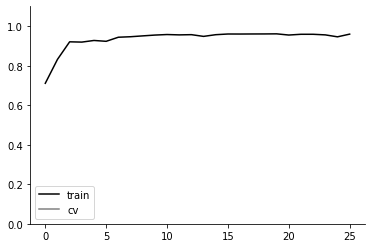

In [7]:
# test a model with "grouped" embedding
tf.random.set_seed(0)
np.random.seed(0)

model = CNNModel(kernel_size=15,
                 amino_acids=["ST", "EDFVM", "QRKIA"], # set the groups, the ones left out get into a separate group
                 learning_rate=0.1)

features = Tools.get_features(sequences, model)

X, y = Tools.shuffle_data(features, targets)

# a simple fit on all data

model.fit(X, y, epochs=200, 

          verbose=False,

          validation_split=0.0,

          class_weight={0: 0.5, 1: 0.5},

          converge_threshold=0.8,

          patience=10,

          early_stop=True)

model.display_training()

In [8]:
# ROC AUC and classification report on the training data
predictions = model.model.predict(X)
print(f"ROC AUC: {roc_auc_score(y, predictions):.3f}")
print(classification_report(y, (predictions>0.5)))

ROC AUC: 0.963
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        63
           1       0.94      0.88      0.91        50

    accuracy                           0.92       113
   macro avg       0.92      0.92      0.92       113
weighted avg       0.92      0.92      0.92       113



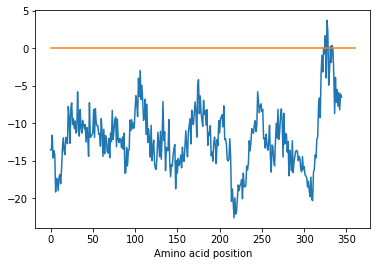

In [9]:
# check the convolution of a single receptor
rec = "AGTRA_RAT"
seq = dataset.loc[rec].Sequence
convoluted = model.convolute_sequence(seq)
plt.plot(convoluted)
plt.plot([1,len(seq)+1], [0,0])
plt.xlabel("Amino acid position")
plt.show()

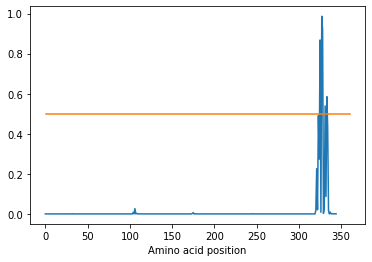

In [10]:
# do a sigmoid transformation on the convolutional values 
def sigmoid(x, sigmoid_weight, sigmoid_bias):
    return 1 / (1 + np.exp(-sigmoid_weight * x - sigmoid_bias))

# get the sigmoid function parameters from the model
sigmoid_bias = float(model.model.get_weights()[-1].reshape(-1)[0])
sigmoid_weight = float(model.model.get_weights()[-2].reshape(-1)[0])

transformed = sigmoid(convoluted, sigmoid_weight, sigmoid_bias)
plt.plot(transformed)
plt.plot([1,len(seq)+1], [0.5,0.5])
plt.xlabel("Amino acid position")
plt.show()

In [11]:
# get the binding region
Tools.get_binding_region(dataset.loc[rec].Sequence, model, 0)

'SSLSTKMSTLSYRPS'

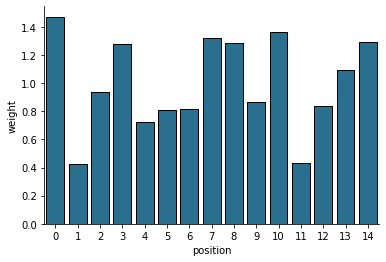

In [12]:
# check the trained kernel
model.display_kernel()

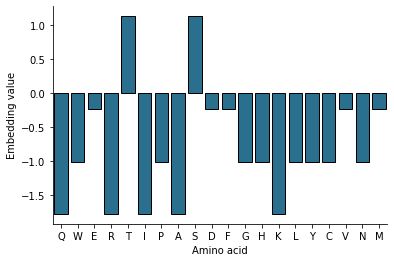

In [13]:
# check the embeddings
model.display_embeddings()

In [14]:
# predict any protein
name = "HTSF1_HUMAN"
seq, scores = Tools.get_alphafold_data(name)
structured = [1 if score>70 else 0 for (idx,score) in enumerate(scores)]
convoluted = model.convolute_sequence(seq)
transformed = sigmoid(convoluted, sigmoid_weight, sigmoid_bias)

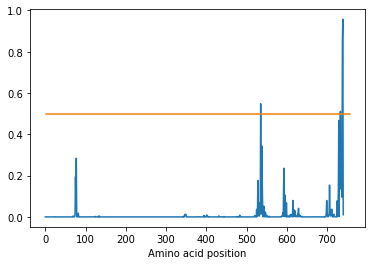

In [15]:
plt.plot(transformed)
plt.plot([1,len(seq)+1], [0.5,0.5])
plt.xlabel("Amino acid position")
plt.show()

In [16]:
# get the binding region and position
Tools.get_binding_region(seq, model, 0), np.argmax(transformed)

('TGSSFILSSDDDDDD', 739)